In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

2025-05-24 05:44:31.008163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748065471.508539      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748065471.626355      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os, shutil
import zipfile
import random
from random import sample
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [4]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import utils
from sklearn.utils.class_weight import compute_class_weight

In [6]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
import numpy as np

In [7]:
train_dir = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_dir = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

In [8]:
def get_data(data_dir) :
    images = []
    labels = []
    
    dir_list = os.listdir(data_dir)
    for i in range(len(dir_list)):
        print("Obtaining images of", dir_list[i], "...")
        for image in os.listdir(data_dir + "/" + dir_list[i]):
            img = cv2.imread(data_dir + '/' + dir_list[i] + '/' + image)
            img = cv2.resize(img, (64, 64))
            images.append(img)
            labels.append(i)
    
    return images, labels
        
X, y = get_data(train_dir)

Obtaining images of N ...
Obtaining images of R ...
Obtaining images of space ...
Obtaining images of B ...
Obtaining images of I ...
Obtaining images of del ...
Obtaining images of F ...
Obtaining images of H ...
Obtaining images of E ...
Obtaining images of U ...
Obtaining images of M ...
Obtaining images of X ...
Obtaining images of K ...
Obtaining images of Q ...
Obtaining images of Y ...
Obtaining images of S ...
Obtaining images of G ...
Obtaining images of A ...
Obtaining images of O ...
Obtaining images of T ...
Obtaining images of V ...
Obtaining images of Z ...
Obtaining images of C ...
Obtaining images of P ...
Obtaining images of L ...
Obtaining images of W ...
Obtaining images of D ...
Obtaining images of nothing ...
Obtaining images of J ...


In [9]:
print(len(X), len(y))

87000 87000


In [10]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

In [11]:
def preprocess_data(X, y):
    np_X = np.array(X)
    normalised_X = np_X.astype('float32')/255.0
    
    label_encoded_y = utils.to_categorical(y)
    
    x_train, x_test, y_train, y_test = train_test_split(normalised_X, label_encoded_y, test_size = 0.2)
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = preprocess_data(X, y)

In [12]:
print("Training data:", x_train.shape)
print("Test data:", x_test.shape)

Training data: (69600, 64, 64, 3)
Test data: (17400, 64, 64, 3)


In [13]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(class_weights))

In [14]:
IMG_SHAPE = (64, 64, 3)
base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# Freeze sebagian besar layer
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # sesuai jumlah kelas
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1748066309.480088      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748066309.480916      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 2, 2, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,081,821 (11.76 MB)

 Trainable params: 2,350,237 (8.97 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [15]:
early_stopper = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint('mobilenet_best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# === Training ===
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=15,
    callbacks=[early_stopper, reduce_lr, checkpoint],
    class_weight=class_weights,
    batch_size=32  # tambahkan batch_size karena tidak pakai generator
)

Epoch 1/15


I0000 00:00:1748066337.337653      61 service.cc:148] XLA service 0x7b94cc014250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748066337.343519      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748066337.343545      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748066339.075393      61 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748066343.152539      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748066343.286592      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  12/2175 ━━━━━━━━━━━━━━━━━━━━ 32s 15ms/step - accuracy: 0.0620 - loss: 3.4826

I0000 00:00:1748066348.855800      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2170/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6983 - loss: 1.0539
Epoch 1: val_accuracy improved from -inf to 0.94207, saving model to mobilenet_best_model.h5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 60s 16ms/step - accuracy: 0.6987 - loss: 1.0524 - val_accuracy: 0.9421 - val_loss: 0.2592 - learning_rate: 5.0000e-04
Epoch 2/15
2174/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9486 - loss: 0.1851
Epoch 2: val_accuracy improved from 0.94207 to 0.96483, saving model to mobilenet_best_model.h5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9486 - loss: 0.1851 - val_accuracy: 0.9648 - val_loss: 0.1455 - learning_rate: 5.0000e-04
Epoch 3/15
2174/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9638 - loss: 0.1337
Epoch 3: val_accuracy improved from 0.96483 to 0.96787, saving model to mobilenet_best_model.h5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9638 - loss: 0.1337 - val_accuracy: 0.9679 - val_loss: 0.1383 - learning_rate: 5.0000e-04
Epoch 4/15
2170

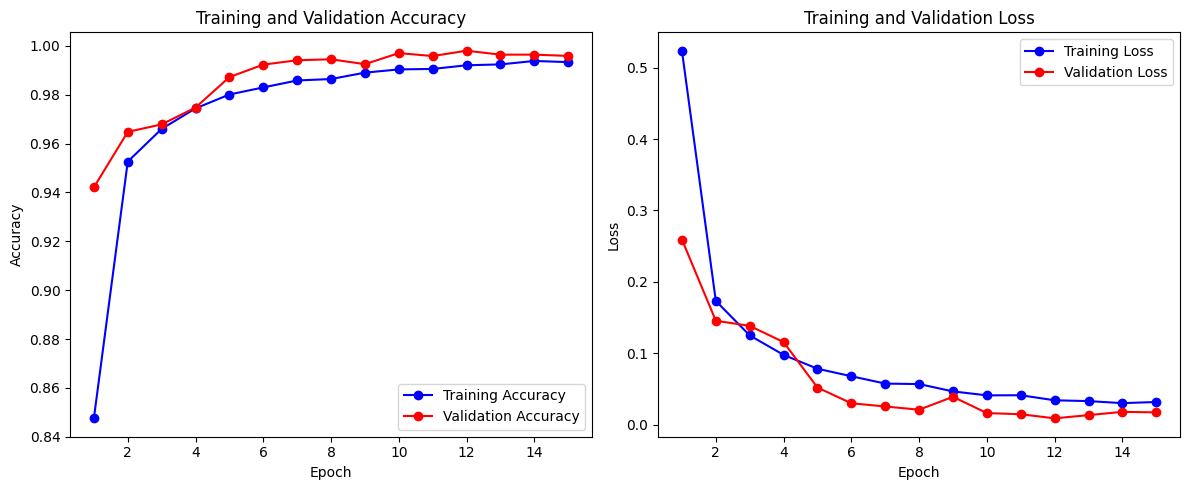

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Grafik Akurasi
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan grafik
plot_training_history(history)

In [17]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# === CLASSIFICATION REPORT ===
y_pred_test = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_test, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))

544/544 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           A       1.00      0.99      1.00       631
           B       0.99      1.00      0.99       624
           C       1.00      1.00      1.00       566
           D       1.00      1.00      1.00       603
           E       1.00      1.00      1.00       613
           F       1.00      1.00      1.00       613
           G       1.00      1.00      1.00       568
           H       1.00      1.00      1.00       596
           I       1.00      1.00      1.00       606
           J       0.99      0.98      0.99       576
           K       1.00      1.00      1.00       611
           L       1.00      1.00      1.00       584
           M       1.00      1.00      1.00       597
           N       1.00      1.00      1.00       592
           O       0.99      1.00      1.00       577
           P       1.00      1.00      1.00       583
       

In [18]:
import tensorflow as tf

# Load model .h5
model = tf.keras.models.load_model('mobilenet_best_model.h5')

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan ke file
with open('model_mobilenet.tflite', 'wb') as f:
    f.write(tflite_model)

print("✅ Model berhasil dikonversi ke TFLite dan disimpan sebagai 'model_mobilenet.tflite'")

Saved artifact at '/tmp/tmp8pwb7sjp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float32, name=None)
Captures:
  135882463652816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135882463655504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135882463652432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135882463642448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135882463653008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135882463653584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135879314080784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135879314080208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135882463653392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135879314081168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13587931408232

W0000 00:00:1748066759.440482      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748066759.440522      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1748066759.603764      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


✅ Model berhasil dikonversi ke TFLite dan disimpan sebagai 'model_mobilenet.tflite'


In [19]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible

In [20]:
!tensorflowjs_converter \
    --input_format=keras \
    --output_format=tfjs_graph_model \
    mobilenet_best_model.h5 \
    tfjs_model/


2025-05-24 06:06:12.527705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748066772.550989     533 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748066772.558193     533 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
I0000 00:00:1748066780.671335     533 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5602 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748066780.672116     533 gpu_device.cc:2022] Created device /job:localhost/replica:0/